In [1]:
# import packages
# pandas, plotting, other basics 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# metrics and other useful tools 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer

# Algos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor

#from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor

# Grid search model selection 
from sklearn.model_selection import GridSearchCV


# deep net as last
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor



In [2]:
# read in train and test data
train_df = pd.read_csv(r"E:\github_repos\PRIVATE\Private_Active_Projects\post_HCT_survival_analysis\data\train.csv")
test_df = pd.read_csv(r"E:\github_repos\PRIVATE\Private_Active_Projects\post_HCT_survival_analysis\data\test.csv")

In [3]:
train_df.shape

(28800, 60)

In [4]:
# lets drop any columns from train not in test, easier for now
main_ivs = ['efs','efs_time']  

columns_to_drop_from_train = [col for col in train_df.columns if col not in test_df.columns and col not in main_ivs]

train_df = train_df.drop(columns_to_drop_from_train)

In [5]:
# Okay, lets set up a way to split numeric from categorical 
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns

In [6]:
# Lets first assess missing for numeric dat
#print(train_df[numeric_columns].isnull().mean() * 100)
# Highest is 24%, I am fine i think with imputing that with the mean

In [7]:
# Lets now assess missing for categorical dat
#print(train_df[categorical_columns].isnull().mean() * 100)
# So some decent missing data, but probably valueable data, I think we should go ahead and set the NAN as a missing cateogory

In [8]:
# before preprocessing, sort into x and y
columns_to_drop = ['efs','efs_time']

# Dynamically drop columns if they exist
x_train = train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns])
y_train = train_df['efs']

x_test = test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns])

In [9]:
# lets split the x_train into cat and numeric values
numeric_train_cols = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_train_cols = x_train.select_dtypes(include=['object', 'category']).columns

In [10]:
# start some data preprocssing 
# Will apply same mean impute based on train, apply to test
for col in numeric_train_cols:
    mean_value = x_train[col].mean()  # Calculate mean from train_df
    x_train[col] = x_train[col].fillna(mean_value)  # Impute in train_df
    x_test[col] = x_test[col].fillna(mean_value)  # Impute in test_df with the same mean

In [11]:
# next, standardize numeric values
scaler = StandardScaler()
x_train[numeric_train_cols] = scaler.fit_transform(x_train[numeric_train_cols])
x_test[numeric_train_cols] = scaler.transform(x_test[numeric_train_cols])

In [12]:
# for prepocessing of categorical
# Need to fix two variables whoses names and values will get messy after scaling and dummy varibales
x_train['tbi_status'] = x_train['tbi_status'].replace({'TBI +- Other, >cGy': 'TBI_Other_GreatercGY'
                                             , 'TBI +- Other, <=cGy': 'TBI_Other_LesserEqualcGY'})

x_train['cmv_status'] = x_train['cmv_status'].replace({'+/+': 'pospos'
                                                     , '-/+': 'negpos'
                                                      , '+/-': 'posneg'
                                                      , '-/-': 'negneg'})


In [13]:
# Now lets replace values with standardized values removing white space, etc
for col in categorical_train_cols:
    x_train[col] = x_train[col].str.replace(r'[^a-zA-Z0-9]', '_', regex=True)
    x_test[col] = x_test[col].str.replace(r'[^a-zA-Z0-9]', '_', regex=True)   

In [14]:
# For categorical, lets replace all missing with a "missing" value 
x_train[categorical_train_cols] = x_train[categorical_train_cols].fillna('Missing_value') 
x_test[categorical_train_cols] = x_test[categorical_train_cols].fillna('Missing_value') 

In [15]:
# last, lets dummy code the categorical variables and build up the final train and test data\
# first concatenate train and test DataFrames for consistent dummy encoding
combined = pd.concat([x_train, x_test], axis=0)

# Perform one-hot encoding
combined_encoded = pd.get_dummies(combined, columns=categorical_train_cols, drop_first=True)

# Split back into train and test sets
x_train_encoded = combined_encoded.iloc[:len(x_train), :].copy()
x_test_encoded = combined_encoded.iloc[len(x_train):, :].copy()

In [16]:
def regression_model_evaluation(y_train_test, y_pred):
    # fit metrics
    r2 = r2_score(y_train_test, y_pred)
    mse = mean_squared_error(y_train_test, y_pred)
    mae = mean_absolute_error(y_train_test, y_pred)

    # print results
    print(f"R-squared: {r2:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")

In [17]:
#############################################################
##  interactions   ##
#############################################################

In [18]:
# Step 1: Generate Interaction Terms for X_train and X_test
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [18]:
# Generate interaction terms for the training data
x_train_interactions = poly.fit_transform(x_train_encoded)

In [19]:
# Generate interaction terms for the test data (use the same transformation as training data)
x_test_interactions = poly.transform(x_test_encoded)

In [20]:
# Define custom delimiter
custom_delimiter = "|"

# Get original feature names
feature_names = poly.get_feature_names_out(x_train_encoded.columns)

# Modify feature names to use custom delimiter
custom_feature_names = [name.replace(" ", custom_delimiter) for name in feature_names]


In [21]:
# Convert to DataFrame with renamed columns
x_train_interactions = pd.DataFrame(x_train_interactions, columns=custom_feature_names)
x_test_interactions = pd.DataFrame(x_test_interactions, columns=custom_feature_names)


In [22]:
x_test_interactions.head(5)

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,cardiac_Not_done|cardiac_Yes,cardiac_Not_done|pulm_moderate_No,cardiac_Not_done|pulm_moderate_Not_done,cardiac_Not_done|pulm_moderate_Yes,cardiac_Yes|pulm_moderate_No,cardiac_Yes|pulm_moderate_Not_done,cardiac_Yes|pulm_moderate_Yes,pulm_moderate_No|pulm_moderate_Not_done,pulm_moderate_No|pulm_moderate_Yes,pulm_moderate_Not_done|pulm_moderate_Yes
0,1.732111,-5.610384e-16,-6.357585e-16,0.753386,0.811944,1.075758e-15,0.649272,0.755021,0.585379,0.661997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.732231,5.949953e-01,8.039862e-01,0.753386,0.811944,8.374026e-01,0.649272,0.755021,0.585379,0.661997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.732352,5.949953e-01,8.039862e-01,0.753386,0.811944,8.374026e-01,0.649272,0.755021,0.585379,0.661997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
coefficients = linear_model.coef_

# Create a DataFrame mapping feature names to coefficients
coef_df = pd.DataFrame({
    "Feature": custom_feature_names,
    "Coefficient": coefficients
})

# Compute absolute importance
coef_df["Importance"] = np.abs(coef_df["Coefficient"])

# Filter only interaction terms (those containing the delimiter '|')
interaction_terms_df = coef_df[coef_df["Feature"].str.contains(custom_delimiter)]

# Sort by importance and get top 10
top_10_interactions = interaction_terms_df.sort_values(by="Importance", ascending=False)

top_10_interactions.to_csv("dat.csv")

In [19]:
# List of top 40 feature pairs
top_40_pairs = [
    "hla_low_res_6|tce_div_match_Permissive_mismatched",
    "hla_low_res_6|tce_div_match_Missing_value",
    "hla_low_res_6|tce_div_match_HvG_non_permissive",
    "hla_low_res_6|tce_div_match_GvH_non_permissive",
    "hla_low_res_8|tce_div_match_Permissive_mismatched",
    "hla_low_res_8|tce_div_match_Missing_value",
    "hla_low_res_8|tce_div_match_HvG_non_permissive",
    "hla_low_res_8|tce_div_match_GvH_non_permissive",
    "hla_match_a_low|tce_div_match_Permissive_mismatched",
    "hla_match_a_low|tce_div_match_Missing_value",
    "hla_match_a_low|tce_div_match_HvG_non_permissive",
    "hla_match_a_low|tce_div_match_GvH_non_permissive",
    "hla_match_b_low|tce_div_match_Missing_value",
    "hla_match_b_low|tce_div_match_Permissive_mismatched",
    "hla_match_b_low|tce_div_match_HvG_non_permissive",
    "hla_match_b_low|tce_div_match_GvH_non_permissive",
    "hla_match_drb1_low|tce_div_match_Missing_value",
    "hla_match_drb1_low|tce_div_match_Permissive_mismatched",
    "hla_match_drb1_low|tce_div_match_HvG_non_permissive",
    "hla_match_drb1_low|tce_div_match_GvH_non_permissive",
    "hla_match_c_low|tce_div_match_Permissive_mismatched",
    "hla_match_c_low|tce_div_match_HvG_non_permissive",
    "hla_match_c_low|tce_div_match_Missing_value",
    "hla_match_c_low|tce_div_match_GvH_non_permissive",
    "rheum_issue_Yes|donor_related_Related",
    "rheum_issue_Yes|donor_related_Unrelated",
    "rheum_issue_Yes|donor_related_Multiple_donor__non_UCB_",
    "cyto_score_Normal|donor_related_Related",
    "cyto_score_Normal|donor_related_Unrelated",
    "cyto_score_Normal|donor_related_Multiple_donor__non_UCB_",
    "tce_imm_match_H_B|donor_related_Related",
    "ethnicity_Non_resident_of_the_U_S_|rheum_issue_Not_done",
    "prim_disease_hct_IIS|donor_related_Multiple_donor__non_UCB_",
    "tce_imm_match_H_B|donor_related_Unrelated",
    "rheum_issue_Not_done|cardiac_Yes",
    "pulm_severe_Not_done|hepatic_mild_Not_done",
    "prim_disease_hct_PCD|donor_related_Unrelated",
    "prim_disease_hct_PCD|donor_related_Related",
    "prim_disease_hct_IIS|donor_related_Related",
    "prim_disease_hct_IIS|donor_related_Unrelated",
    "rheum_issue_Not_done|cardiac_Not_done",
    "cyto_score_detail_TBD|rheum_issue_Not_done",
    "prim_disease_hct_PCD|donor_related_Multiple_donor__non_UCB_",
    "hla_low_res_6|gvhd_proph_Missing_value",
    "pulm_severe_Yes|donor_related_Unrelated",
    "hla_low_res_6|gvhd_proph_Other_GVHD_Prophylaxis",
    "pulm_severe_Yes|donor_related_Related",
    "hla_low_res_6|gvhd_proph_CSA_alone",
    "hla_low_res_6|gvhd_proph_TDEPLETION____other",
    "hla_low_res_6|gvhd_proph_FKalone",
    "hla_low_res_6|gvhd_proph_CSA___MTX____others_not_MMF_FK_",
    "hla_low_res_6|gvhd_proph_Cyclophosphamide____others",
    "hepatic_severe_Not_done|donor_related_Related",
    "hla_low_res_6|gvhd_proph_FK__MTX____others_not_MMF_",
    "hla_low_res_6|gvhd_proph_FK__MMF____others",
    "pulm_severe_Yes|donor_related_Multiple_donor__non_UCB_",
    "hla_low_res_6|gvhd_proph_TDEPLETION_alone",
    "hla_low_res_6|gvhd_proph_CDselect_alone",
    "hla_low_res_6|gvhd_proph_Cyclophosphamide_alone",
    "hla_low_res_6|gvhd_proph_CSA___MMF____others_not_FK_",
    "hepatic_severe_Not_done|donor_related_Unrelated",
    "hla_low_res_6|gvhd_proph_No_GvHD_Prophylaxis",
    "tce_match_GvH_non_permissive|pulm_moderate_Not_done",
    "hepatic_severe_Not_done|donor_related_Multiple_donor__non_UCB_",
    "rheum_issue_Not_done|cardiac_No",
    "tbi_status_TBI____Other___cGy__single|peptic_ulcer_Not_done",
    "tbi_status_TBI____Other___cGy__single|rituximab_Yes",
    "tce_match_Missing_value|pulm_moderate_Not_done",
    "peptic_ulcer_Not_done|pulm_moderate_Not_done",
    "pulm_severe_No|donor_related_Unrelated",
    "pulm_severe_No|donor_related_Related",
    "prior_tumor_Not_done|gvhd_proph_CSA_alone",
    "pulm_severe_No|donor_related_Multiple_donor__non_UCB_",
    "rheum_issue_No|donor_related_Related",
    "rheum_issue_No|donor_related_Unrelated",
    "dri_score_Intermediate___TED_AML_case__missing_cytogenetics|donor_related_Multiple_donor__non_UCB_",
    "rheum_issue_No|donor_related_Multiple_donor__non_UCB_",
    "tce_match_Permissive|pulm_moderate_Not_done",
    "prior_tumor_Yes|donor_related_Related",
    "prior_tumor_Yes|donor_related_Unrelated",
    "dri_score_Intermediate___TED_AML_case__missing_cytogenetics|donor_related_Unrelated",
    "prior_tumor_Yes|donor_related_Multiple_donor__non_UCB_",
    "dri_score_Intermediate___TED_AML_case__missing_cytogenetics|donor_related_Related",
    "tce_div_match_HvG_non_permissive|donor_related_Unrelated",
    "tce_div_match_HvG_non_permissive|donor_related_Related",
    "hla_low_res_6|tbi_status_TBI____Other___cGy__single",
    "gvhd_proph_CSA___MTX____others_not_MMF_FK_|rheum_issue_Not_done",
    "gvhd_proph_FKalone|rheum_issue_Not_done",
    "prim_disease_hct_HIS|donor_related_Unrelated",
    "hla_high_res_8|cardiac_Not_done",
    "prim_disease_hct_HIS|donor_related_Related",
    "tbi_status_TBI____Other___cGy__single|gvhd_proph_CSA_alone",
    "in_vivo_tcd_Yes|donor_related_Related",
    "prim_disease_hct_HIS|donor_related_Multiple_donor__non_UCB_",
    "rheum_issue_Not_done|tce_div_match_HvG_non_permissive",
    "prior_tumor_No|gvhd_proph_CSA_alone",
    "tce_div_match_Permissive_mismatched|donor_related_Related",
    "tce_div_match_Permissive_mismatched|donor_related_Unrelated",
    "in_vivo_tcd_Yes|donor_related_Multiple_donor__non_UCB_",
    "in_vivo_tcd_Yes|donor_related_Unrelated",
    "donor_related_Multiple_donor__non_UCB_|melphalan_dose_Missing_value",
    "tce_div_match_HvG_non_permissive|donor_related_Multiple_donor__non_UCB_",
    "hla_high_res_6|rheum_issue_Not_done",
    "graft_type_Peripheral_blood|donor_related_Related",
    "pulm_severe_No|pulm_moderate_Not_done",
    "graft_type_Peripheral_blood|donor_related_Unrelated",
    "rheum_issue_Not_done|tce_div_match_GvH_non_permissive",
    "donor_related_Unrelated|melphalan_dose_Missing_value",
    "donor_related_Related|melphalan_dose_Missing_value",
    "rheum_issue_Not_done|tce_div_match_Missing_value",
    "gvhd_proph_CDselect_alone|rheum_issue_Not_done",
    "tce_div_match_Permissive_mismatched|donor_related_Multiple_donor__non_UCB_",
    "graft_type_Peripheral_blood|donor_related_Multiple_donor__non_UCB_",
    "hla_low_res_8|gvhd_proph_CSA___MTX____others_not_MMF_FK_",
    "prior_tumor_Yes|gvhd_proph_CSA_alone",
    "prod_type_PB|donor_related_Related",
    "conditioning_intensity_TBD|rheum_issue_Not_done",
    "prod_type_PB|donor_related_Unrelated",
    "tbi_status_TBI____Other___cGy__single|prim_disease_hct_NHL",
    "tce_imm_match_H_B|rheum_issue_Not_done",
    "rheum_issue_Yes|cardiac_Not_done",
    "hla_low_res_6|rheum_issue_Not_done",
    "pulm_severe_Yes|pulm_moderate_Not_done",
    "tbi_status_TBI____Other___cGy__single|pulm_severe_No",
    "prim_disease_hct_NHL|rheum_issue_Not_done",
    "prod_type_PB|donor_related_Multiple_donor__non_UCB_",
    "tbi_status_TBI____Other___cGy__single|gvhd_proph_TDEPLETION____other",
    "cyto_score_Other|donor_related_Multiple_donor__non_UCB_",
    "hepatic_mild_Yes|donor_related_Multiple_donor__non_UCB_",
    "rheum_issue_Not_done|tce_div_match_Permissive_mismatched",
    "hepatic_mild_Yes|donor_related_Related",
    "rheum_issue_Not_done|donor_related_Unrelated",
    "cyto_score_Other|donor_related_Related",
    "hepatic_mild_Yes|donor_related_Unrelated",
    "renal_issue_Yes|rheum_issue_Not_done",
    "sex_match_Missing_value|donor_related_Multiple_donor__non_UCB_",
    "prim_disease_hct_PCD|rheum_issue_Not_done",
    "cyto_score_Other|donor_related_Unrelated",
    "cyto_score_Missing_value|rheum_issue_Not_done",
    "sex_match_Missing_value|donor_related_Unrelated",
    "sex_match_Missing_value|donor_related_Related",
    "tce_match_GvH_non_permissive|rheum_issue_Not_done",
    "prim_disease_hct_Other_leukemia|donor_related_Unrelated",
    "prim_disease_hct_Other_leukemia|donor_related_Related",
    "tce_match_HvG_non_permissive|pulm_moderate_Not_done",
    "hla_high_res_6|donor_related_Unrelated",
    "tce_div_match_Permissive_mismatched|pulm_moderate_Not_done",
    "hla_high_res_6|donor_related_Multiple_donor__non_UCB_",
    "hla_high_res_6|donor_related_Related",
    "tbi_status_TBI_Other_LesserEqualcGY|donor_related_Related",
    "ethnicity_Missing_value|rheum_issue_Not_done",
    "peptic_ulcer_No|donor_related_Related",
    "tbi_status_TBI_Other_LesserEqualcGY|donor_related_Unrelated",
    "prim_disease_hct_HIS|pulm_moderate_Not_done",
    "tbi_status_TBI____Other___cGy__single|obesity_No",
    "peptic_ulcer_No|donor_related_Unrelated",
    "hla_high_res_10|cardiac_Not_done",
    "obesity_Not_done|pulm_moderate_Not_done",
    "tbi_status_TBI____Other___cGy__single|rheum_issue_No",
    "tbi_status_TBI____Other___cGy__single|obesity_Yes",
    "peptic_ulcer_Yes|hepatic_mild_No",
    "tbi_status_TBI_Other_LesserEqualcGY|donor_related_Multiple_donor__non_UCB_",
    "peptic_ulcer_Yes|hepatic_mild_Yes",
    "cmv_status_negpos|donor_related_Unrelated",
    "ethnicity_Non_resident_of_the_U_S_|donor_related_Related",
    "peptic_ulcer_No|donor_related_Multiple_donor__non_UCB_",
    "dri_score_Missing_value|renal_issue_Not_done",
    "tbi_status_TBI____Other___cGy__single|pulm_severe_Not_done",
    "tbi_status_TBI____Other___cGy__single|donor_related_Multiple_donor__non_UCB_",
    "ethnicity_Non_resident_of_the_U_S_|donor_related_Unrelated",
    "ethnicity_Non_resident_of_the_U_S_|donor_related_Multiple_donor__non_UCB_",
    "cmv_status_negpos|donor_related_Related",
    "dri_score_N_A___non_malignant_indication|rheum_issue_Not_done",
    "hepatic_severe_Yes|donor_related_Unrelated",
    "hla_low_res_8|gvhd_proph_CSA_alone",
    "prim_disease_hct_Other_leukemia|donor_related_Multiple_donor__non_UCB_",
    "hepatic_severe_Yes|donor_related_Related",
    "in_vivo_tcd_Yes|cardiac_Not_done",
    "rheum_issue_Not_done|hepatic_mild_Not_done",
    "hepatic_severe_No|donor_related_Unrelated",
    "peptic_ulcer_No|rheum_issue_Not_done",
    "gvhd_proph_TDEPLETION_alone|donor_related_Unrelated",
    "hepatic_severe_No|donor_related_Related",
    "hepatic_mild_Not_done|donor_related_Related",
    "tce_div_match_Missing_value|pulm_moderate_Not_done",
    "cmv_status_negpos|donor_related_Multiple_donor__non_UCB_",
    "hepatic_severe_No|donor_related_Multiple_donor__non_UCB_",
    "prim_disease_hct_HIS|rheum_issue_Not_done",
    "vent_hist_Yes|pulm_moderate_Not_done",
    "psych_disturb_Not_done|pulm_moderate_Not_done",
    "hepatic_severe_Yes|donor_related_Multiple_donor__non_UCB_",
    "dri_score_Intermediate___TED_AML_case__missing_cytogenetics|tbi_status_TBI____Other___cGy__single",
    "pulm_severe_No|gvhd_proph_CSA_alone",
    "vent_hist_No|pulm_moderate_Not_done",
    "arrhythmia_Yes|pulm_moderate_Not_done",
    "tbi_status_TBI____Other___cGy__single|melphalan_dose_Missing_value",
    "hla_low_res_8|tbi_status_TBI____Other___cGy__single",
    "hla_low_res_8|gvhd_proph_TDEPLETION____other",
    "prim_disease_hct_MDS|rheum_issue_Not_done",
    "hla_low_res_8|gvhd_proph_Missing_value",
    "dri_score_TBD_cytogenetics|donor_related_Unrelated",
    "dri_score_Missing_value|pulm_moderate_Not_done",
    "ethnicity_Not_Hispanic_or_Latino|rheum_issue_Not_done"    
]

In [20]:
def create_interaction(df, top_40_pairs):
    # Dictionary to store interaction columns
    new_columns = {}
    
    # Loop through the pairs and create interaction terms
    for pair in top_40_pairs:
        feature1, feature2 = pair.split('|')
        
        # Create interaction term by multiplying the two features
        interaction_column = df[feature1] * df[feature2]
        
        # Store the interaction column in the dictionary
        new_columns[pair] = interaction_column
    
    # Add all interaction columns to the DataFrame at once
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)
    
    return df

In [21]:
# Apply the interaction creation to both training and testing datasets
x_train_encoded = create_interaction(x_train_encoded, top_40_pairs)
x_test_encoded = create_interaction(x_test_encoded, top_40_pairs)

(28800, 587)

In [27]:
#############################################################
## New section for testing algos   ##
#############################################################

In [28]:
#############################################################
## normal linear regression  ##
#############################################################

In [61]:
linear_model = LinearRegression()
linear_model.fit(x_train_encoded, y_train)

LinearRegression()

In [62]:
y_linear_pred = linear_model.predict(x_train_encoded)
regression_model_evaluation(y_train, y_linear_pred)

R-squared: 0.198
Mean Squared Error (MSE): 0.199
Mean Absolute Error (MAE): 0.401


In [21]:
#############################################################
## rf regression  ##
#############################################################

In [22]:
# Step 1: Define hyperparameter grid for RandomForestRegressor
n_estimators_values = [50, 100, 200]  # Number of trees in the forest
max_depth_values = [4, 6, 10]  # Maximum depth of the trees
min_samples_split_values = [2, 5, 10]  # Minimum number of samples required to split an internal node
min_samples_leaf_values = [1, 2, 4]  # Minimum number of samples required to be at a leaf node

# Step 2: Create the parameter grid
randomforest_param_grid = {
    'n_estimators': n_estimators_values,
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values,
}

# Step 3: Set up the regressor
randomforest_regressor = RandomForestRegressor(
    random_state=42
)

# Step 4: Build the GridSearchCV model
randomforest_grid_search = GridSearchCV(
    estimator=randomforest_regressor,
    param_grid=randomforest_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R^2 as the scoring metric
    n_jobs=-4,  # Use but three cores
    verbose=1  # Output progress
)

In [23]:
# Step 5: Fit the grid search
randomforest_grid_search.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-4,
             param_grid={'max_depth': [4, 6, 10], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2', verbose=1)

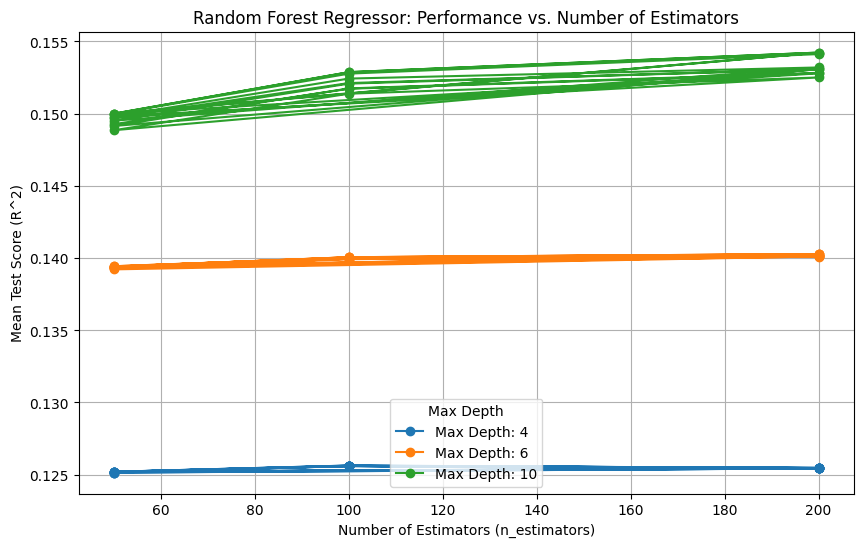

In [24]:
# Extract results from GridSearchCV for RandomForestRegressor
randomforest_results = pd.DataFrame(randomforest_grid_search.cv_results_)

# Plot performance for different 'n_estimators' values grouped by 'max_depth'
plt.figure(figsize=(10, 6))

# Loop over 'max_depth' values
for max_depth in max_depth_values:
    subset = randomforest_results[randomforest_results['param_max_depth'] == max_depth]
    plt.plot(
        subset['param_n_estimators'],  # Plot for different 'n_estimators' values
        subset['mean_test_score'],  # R^2 values are stored in 'mean_test_score'
        marker='o',
        label=f'Max Depth: {max_depth}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (R^2)')
plt.title('Random Forest Regressor: Performance vs. Number of Estimators')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

In [56]:
# Step 6: Get the best parameters for RandomForestRegressor
best_params = randomforest_grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [57]:
# Step 7: Fit the final RandomForestRegressor model using the best parameters found
best_randomforest_regressor = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params.get('max_depth', None),  # Fallback to None if missing
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

best_randomforest_regressor.fit(x_train_encoded, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=200,
                      random_state=42)

In [58]:
# Step 8: Model evaluation
y_rf_pred_train = best_randomforest_regressor.predict(x_train_encoded)

# Evaluate model
regression_model_evaluation(y_train, y_rf_pred_train)

R-squared: 0.277
Mean Squared Error (MSE): 0.180
Mean Absolute Error (MAE): 0.390


In [28]:
#############################################################
## gbm regression  ##
#############################################################

In [29]:
# Step 1: Define hyperparameter grid for GradientBoostingRegressor
n_estimators_values = [50, 100, 200]  # Number of boosting stages
learning_rate_values = [0.01, 0.1, 0.3]  # Learning rate shrinks the contribution of each tree
max_depth_values = [3, 5, 7]  # Maximum depth of the individual regression estimators
min_samples_split_values = [2, 5, 10]  # Minimum number of samples required to split an internal node
min_samples_leaf_values = [1, 2, 4]  # Minimum number of samples required to be a leaf node

# Step 2: Create the parameter grid
gbr_param_grid = {
    'n_estimators': n_estimators_values,
    'learning_rate': learning_rate_values,
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values,
}

# Step 3: Set up the regressor
gbr_regressor = GradientBoostingRegressor(
    random_state=42
)

# Step 4: Build the GridSearchCV model
gbr_grid_search = GridSearchCV(
    estimator=gbr_regressor,
    param_grid=gbr_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R^2 as the scoring metric
    n_jobs=-4,  # Use all available cores
    verbose=1  # Output progress
)

In [30]:
# Step 5: Fit the grid search
gbr_grid_search.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-4,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2', verbose=1)

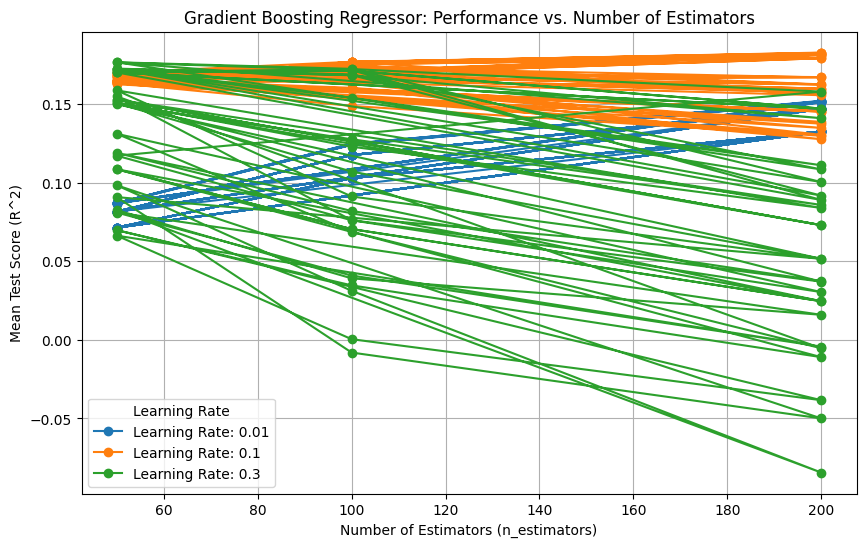

In [31]:
# Extract results from GridSearchCV for GradientBoostingRegressor
gbr_results = pd.DataFrame(gbr_grid_search.cv_results_)

# Plot performance for different 'n_estimators' values grouped by 'learning_rate'
plt.figure(figsize=(10, 6))

# Loop over 'learning_rate' values
for learning_rate in learning_rate_values:
    subset = gbr_results[gbr_results['param_learning_rate'] == learning_rate]
    plt.plot(
        subset['param_n_estimators'],  # Plot for different 'n_estimators' values
        subset['mean_test_score'],  # R^2 values are stored in 'mean_test_score'
        marker='o',
        label=f'Learning Rate: {learning_rate}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (R^2)')
plt.title('Gradient Boosting Regressor: Performance vs. Number of Estimators')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()

In [32]:
# Step 6: Get the best parameters for GradientBoostingRegressor
best_params = gbr_grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [33]:
# Step 7: Fit the final GradientBoostingRegressor model using the best parameters found
best_gbr_regressor = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

best_gbr_regressor.fit(x_train_encoded, y_train)

GradientBoostingRegressor(min_samples_split=10, n_estimators=200,
                          random_state=42)

In [34]:
# Step 8: Model evaluation
y_gbr_pred_train = best_gbr_regressor.predict(x_train_encoded)


# Evaluate model
regression_model_evaluation(y_train, y_gbr_pred_train)

R-squared: 0.232
Mean Squared Error (MSE): 0.191
Mean Absolute Error (MAE): 0.396


In [35]:
#############################################################
## AdaBoostRegressor  ##
#############################################################

In [50]:
# Step 1: Define hyperparameter grid for AdaBoostRegressor
n_estimators_values = [50, 100, 200]  # Number of boosting stages
learning_rate_values = [0.01, 0.1, 0.3, 1.0]  # Learning rate shrinks the contribution of each tree
base_estimator_depth_values = [3, 5, 7]  # Depth of the base estimator (DecisionTreeRegressor)

# Step 2: Create the parameter grid (Use 'estimator' instead of 'base_estimator')
adaboost_param_grid = {
    'n_estimators': n_estimators_values,
    'learning_rate': learning_rate_values,
    'estimator': [DecisionTreeRegressor(max_depth=depth) for depth in base_estimator_depth_values],
}

# Step 3: Set up the regressor
adaboost_regressor = AdaBoostRegressor(random_state=42)

# Step 4: Build the GridSearchCV model
adaboost_grid_search = GridSearchCV(
    estimator=adaboost_regressor,
    param_grid=adaboost_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R^2 as the scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=1  # Output progress
)

In [51]:
# Step 5: Fit the grid search
adaboost_grid_search.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=42), n_jobs=-1,
             param_grid={'estimator': [DecisionTreeRegressor(max_depth=3),
                                       DecisionTreeRegressor(max_depth=5),
                                       DecisionTreeRegressor(max_depth=7)],
                         'learning_rate': [0.01, 0.1, 0.3, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='r2', verbose=1)

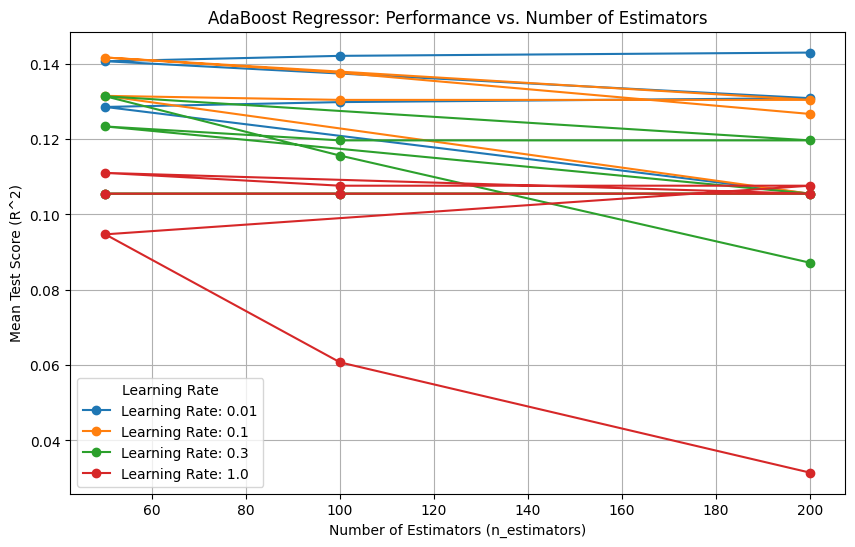

In [52]:
# Extract results from GridSearchCV for AdaBoostRegressor
adaboost_results = pd.DataFrame(adaboost_grid_search.cv_results_)

# Plot performance for different 'n_estimators' values grouped by 'learning_rate'
plt.figure(figsize=(10, 6))

# Loop over 'learning_rate' values
for learning_rate in learning_rate_values:
    subset = adaboost_results[adaboost_results['param_learning_rate'] == learning_rate]
    plt.plot(
        subset['param_n_estimators'],  # Plot for different 'n_estimators' values
        subset['mean_test_score'],  # R^2 values are stored in 'mean_test_score'
        marker='o',
        label=f'Learning Rate: {learning_rate}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (R^2)')
plt.title('AdaBoost Regressor: Performance vs. Number of Estimators')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()

In [53]:
# Step 6: Get the best parameters for AdaBoostRegressor
best_params = adaboost_grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'estimator': DecisionTreeRegressor(max_depth=7), 'learning_rate': 0.01, 'n_estimators': 200}


In [63]:
# Step 7: Fit the final AdaBoostRegressor model using the best parameters found
best_adaboost_regressor = AdaBoostRegressor(
    n_estimators=best_params.get('n_estimators', 50),  # Default to 50 if missing
    learning_rate=best_params.get('learning_rate', 1.0),  # Default to 1.0 if missing
    estimator=best_params.get('estimator', DecisionTreeRegressor(max_depth=3)),  # Use 'estimator'
    random_state=42
)

best_adaboost_regressor.fit(x_train_encoded, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=200, random_state=42)

In [64]:
# Step 8: Model evaluation
y_adaboost_pred_train = best_adaboost_regressor.predict(x_train_encoded)


# Evaluate model
regression_model_evaluation(y_train, y_adaboost_pred_train)

R-squared: 0.110
Mean Squared Error (MSE): 0.221
Mean Absolute Error (MAE): 0.440


In [44]:
#############################################################
## BaggingRegressor  ##
#############################################################

In [65]:
# Step 1: Define hyperparameter grid for BaggingRegressor
n_estimators_values = [10, 50, 100, 200]  # Number of base estimators
max_samples_values = [0.5, 0.7, 1.0]  # Fraction of training samples per estimator
max_features_values = [0.5, 0.7, 1.0]  # Fraction of features per estimator
base_estimator_depth_values = [3, 5, 7]  # Depth of the DecisionTreeRegressor

# Step 2: Create the parameter grid (Use 'estimator' instead of 'base_estimator')
bagging_param_grid = {
    'n_estimators': n_estimators_values,
    'max_samples': max_samples_values,
    'max_features': max_features_values,
    'estimator': [DecisionTreeRegressor(max_depth=depth) for depth in base_estimator_depth_values],
}

# Step 3: Set up the regressor
bagging_regressor = BaggingRegressor(
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Step 4: Build the GridSearchCV model
bagging_grid_search = GridSearchCV(
    estimator=bagging_regressor,
    param_grid=bagging_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R^2 as the scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=1  # Output progress
)

In [66]:
# Step 5: Fit the grid search
bagging_grid_search.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=BaggingRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'estimator': [DecisionTreeRegressor(max_depth=3),
                                       DecisionTreeRegressor(max_depth=5),
                                       DecisionTreeRegressor(max_depth=7)],
                         'max_features': [0.5, 0.7, 1.0],
                         'max_samples': [0.5, 0.7, 1.0],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='r2', verbose=1)

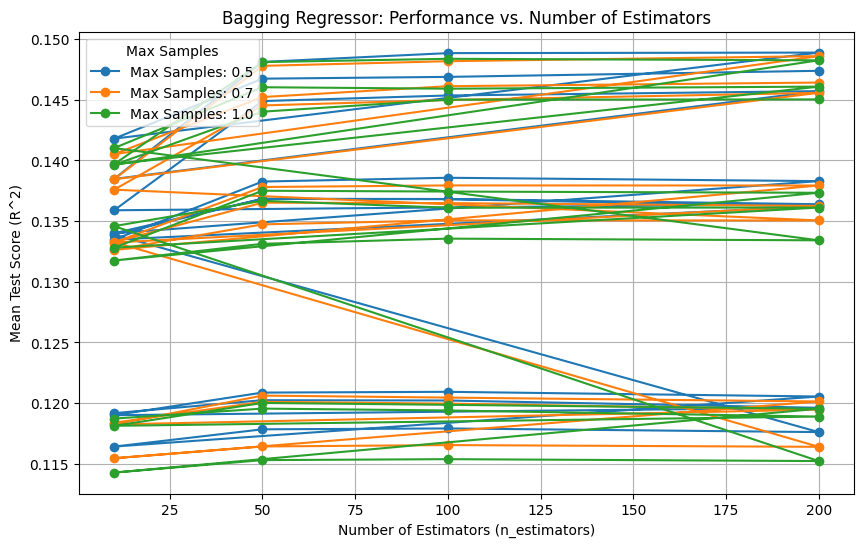

In [67]:
# Extract results from GridSearchCV for BaggingRegressor
bagging_results = pd.DataFrame(bagging_grid_search.cv_results_)

# Plot performance for different 'n_estimators' values grouped by 'max_samples'
plt.figure(figsize=(10, 6))

# Loop over 'max_samples' values
for max_samples in max_samples_values:
    subset = bagging_results[bagging_results['param_max_samples'] == max_samples]
    plt.plot(
        subset['param_n_estimators'],  # Plot for different 'n_estimators' values
        subset['mean_test_score'],  # R^2 values are stored in 'mean_test_score'
        marker='o',
        label=f'Max Samples: {max_samples}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (R^2)')
plt.title('Bagging Regressor: Performance vs. Number of Estimators')
plt.legend(title='Max Samples')
plt.grid(True)
plt.show()

In [68]:
# Step 6: Get the best parameters for BaggingRegressor
best_params = bagging_grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'estimator': DecisionTreeRegressor(max_depth=7), 'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 200}


In [69]:
# Step 7: Fit the final BaggingRegressor model using the best parameters found
best_bagging_regressor = BaggingRegressor(
    n_estimators=best_params.get('n_estimators', 50),  # Default to 50 if missing
    max_samples=best_params.get('max_samples', 1.0),  # Default to 1.0 if missing
    max_features=best_params.get('max_features', 1.0),  # Default to 1.0 if missing
    estimator=best_params.get('estimator', DecisionTreeRegressor(max_depth=3)),  # Use 'estimator' instead of 'base_estimator'
    random_state=42,
    n_jobs=-1
)

best_bagging_regressor.fit(x_train_encoded, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=7), max_features=0.7,
                 max_samples=0.5, n_estimators=200, n_jobs=-1, random_state=42)

In [70]:
# Step 8: Model evaluation
y_bagging_pred_train = best_bagging_regressor.predict(x_train_encoded)


# Evaluate model
regression_model_evaluation(y_train, y_bagging_pred_train)

R-squared: 0.187
Mean Squared Error (MSE): 0.202
Mean Absolute Error (MAE): 0.424


In [ ]:
#############################################################
## ExtraTreesRegressor  ##
#############################################################

In [71]:
# Step 1: Define hyperparameter grid for ExtraTreesRegressor
n_estimators_values = [10, 50, 100, 200]  # Number of trees in the forest
max_depth_values = [None, 5, 10, 20]  # Maximum depth of each tree
max_features_values = ['auto', 'sqrt', 'log2']  # Number of features considered for splitting
min_samples_split_values = [2, 5, 10]  # Minimum samples required to split an internal node
min_samples_leaf_values = [1, 2, 4]  # Minimum number of samples required in a leaf node

# Step 2: Create the parameter grid
extratrees_param_grid = {
    'n_estimators': n_estimators_values,
    'max_depth': max_depth_values,
    'max_features': max_features_values,
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values,
}

# Step 3: Set up the regressor
extratrees_regressor = ExtraTreesRegressor(
    random_state=42,
    n_jobs=-1  # Use all available cores for parallel computation
)

# Step 4: Build the GridSearchCV model
extratrees_grid_search = GridSearchCV(
    estimator=extratrees_regressor,
    param_grid=extratrees_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R^2 as the scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=1  # Output progress
)


In [72]:
# Step 5: Fit the grid search
extratrees_grid_search.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\Mothership\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Mothership\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Mothership\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\Mothership\AppData\Local\Programs\Python\Python310\lib\site-

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='r2', verbose=1)

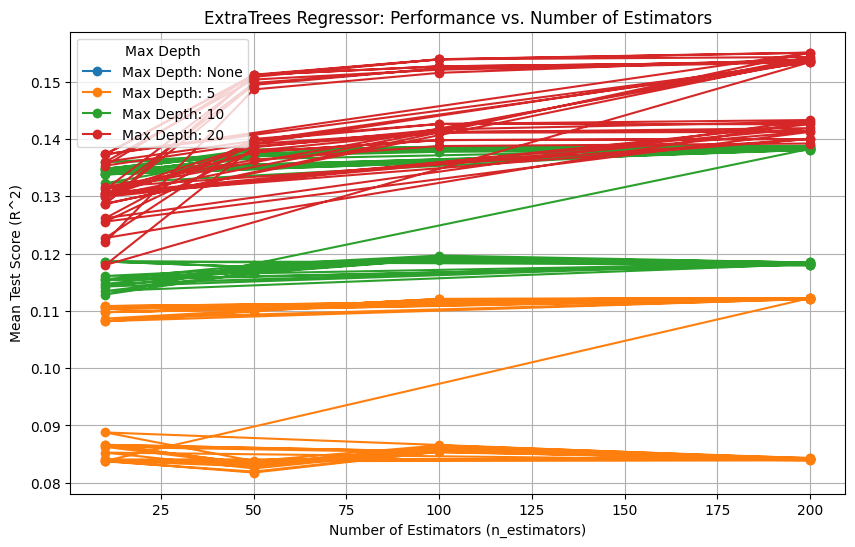

In [73]:
# Extract results from GridSearchCV for ExtraTreesRegressor
extratrees_results = pd.DataFrame(extratrees_grid_search.cv_results_)

# Plot performance for different 'n_estimators' values grouped by 'max_depth'
plt.figure(figsize=(10, 6))

# Loop over 'max_depth' values
for max_depth in max_depth_values:
    subset = extratrees_results[extratrees_results['param_max_depth'] == max_depth]
    plt.plot(
        subset['param_n_estimators'],  # Plot for different 'n_estimators' values
        subset['mean_test_score'],  # R^2 values are stored in 'mean_test_score'
        marker='o',
        label=f'Max Depth: {max_depth}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (R^2)')
plt.title('ExtraTrees Regressor: Performance vs. Number of Estimators')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

In [74]:
# Step 6: Get the best parameters for ExtraTreesRegressor
best_params = extratrees_grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [75]:
# Step 7: Fit the final ExtraTreesRegressor model using the best parameters found
best_extratrees_regressor = ExtraTreesRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

best_extratrees_regressor.fit(x_train_encoded, y_train)

ExtraTreesRegressor(max_depth=20, max_features='sqrt', min_samples_split=10,
                    n_estimators=200, n_jobs=-1, random_state=42)

In [76]:
# Step 8: Model evaluation
y_extratrees_pred_train = best_extratrees_regressor.predict(x_train_encoded)


# Evaluate model
regression_model_evaluation(y_train, y_extratrees_pred_train)

R-squared: 0.517
Mean Squared Error (MSE): 0.120
Mean Absolute Error (MAE): 0.320


In [77]:
#############################################################
## XGBRegressor  ##
#############################################################

In [78]:
# Step 1: Define hyperparameter grid for XGBRegressor
n_estimators_values = [50, 100, 200]  # Number of boosting rounds
learning_rate_values = [0.01, 0.1, 0.3]  # Step size shrinkage
max_depth_values = [3, 6, 9]  # Maximum depth of trees
subsample_values = [0.6, 0.8, 1.0]  # Fraction of samples used per tree
colsample_bytree_values = [0.6, 0.8, 1.0]  # Fraction of features used per tree
reg_lambda_values = [0, 1, 10]  # L2 regularization
reg_alpha_values = [0, 1, 10]  # L1 regularization (Optional)

# Step 2: Create the parameter grid
xgb_param_grid = {
    'n_estimators': n_estimators_values,
    'learning_rate': learning_rate_values,
    'max_depth': max_depth_values,
    'subsample': subsample_values,
    'colsample_bytree': colsample_bytree_values,
    'reg_lambda': reg_lambda_values,
    'reg_alpha': reg_alpha_values,  # Added L1 regularization
}

# Step 3: Set up the regressor
xgb_regressor = XGBRegressor(
    objective='reg:squarederror',  # Use squared error for regression
    random_state=42,
    n_jobs=-1,
    tree_method="hist"  # (Optional) Optimized for larger datasets
)

# Step 4: Build the GridSearchCV model
xgb_grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=xgb_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R^2 as the scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=1  # Output progress
)

In [79]:
# Step 5: Fit the grid search
xgb_grid_search.fit(x_train_encoded, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# Extract results from GridSearchCV for XGBRegressor
xgb_results = pd.DataFrame(xgb_grid_search.cv_results_)

# Plot performance for different 'n_estimators' values grouped by 'learning_rate'
plt.figure(figsize=(10, 6))

# Loop over 'learning_rate' values
for learning_rate in learning_rate_values:
    subset = xgb_results[xgb_results['param_learning_rate'] == learning_rate]
    plt.plot(
        subset['param_n_estimators'],  # Plot for different 'n_estimators' values
        subset['mean_test_score'],  # R^2 values are stored in 'mean_test_score'
        marker='o',
        label=f'Learning Rate: {learning_rate}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (R^2)')
plt.title('XGBRegressor: Performance vs. Number of Estimators')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()

In [ ]:
# Step 6: Get the best parameters for XGBRegressor
best_params = xgb_grid_search.best_params_
print(f"Best Parameters: {best_params}")

In [ ]:
# Step 7: Fit the final XGBRegressor model using the best parameters found
best_xgb_regressor = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_lambda=best_params['reg_lambda'],
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

best_xgb_regressor.fit(x_train_encoded, y_train)

In [ ]:
# Step 8: Model evaluation
y_xgb_pred_train = best_xgb_regressor.predict(x_train_encoded)


# Evaluate model
regression_model_evaluation(y_train, y_xgb_pred_train)

In [ ]:
#############################################################
## Tensorflow  ##
#############################################################

In [ ]:
# Step 1: Define function to create a TensorFlow regression model
def build_model(learning_rate=0.01, num_layers=2, neurons=64, dropout_rate=0.2):
    model = Sequential()
    
    # Input Layer
    model.add(Dense(neurons, activation='relu', input_shape=(x_train_encoded.shape[1],)))
    
    # Hidden Layers
    for _ in range(num_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))  # Regularization
    
    # Output Layer
    model.add(Dense(1))  # Regression output
    
    # Compile Model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    
    return model

# Wrap the model with KerasRegressor for compatibility with GridSearchCV
tf_regressor = KerasRegressor(build_fn=build_model, verbose=0)

# Step 2: Define hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rate for Adam optimizer
    'num_layers': [1, 2, 3],  # Number of hidden layers
    'neurons': [32, 64, 128],  # Number of neurons per layer
    'dropout_rate': [0.2, 0.3, 0.4],  # Dropout regularization
    'batch_size': [16, 32, 64],  # Mini-batch sizes
    'epochs': [50, 100]  # Training epochs
}

# Step 3: Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=tf_regressor,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='r2',  # R^2 for regression performance
    n_jobs=-1,  # Use all available processors
    verbose=1
)

In [ ]:
# Step 4: Fit the grid search
grid_search.fit(x_train_encoded, y_train)

In [ ]:
# Step 5: Extract results and best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

In [ ]:
# Step 6: Train final model using best parameters
best_model = build_model(
    learning_rate=best_params['learning_rate'],
    num_layers=best_params['num_layers'],
    neurons=best_params['neurons'],
    dropout_rate=best_params['dropout_rate']
)

history = best_model.fit(
    x_train_encoded, y_train,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    verbose=1,
    validation_split=0.2
)

In [ ]:
# Step 7: Model evaluation
y_pred_train = best_model.predict(x_train_encoded)

In [ ]:
# Step 8: Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('TensorFlow Regressor: Learning Curve')
plt.legend()
plt.grid(True)
plt.show()